# Duration Prediction

In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import mlflow

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
pd.options.mode.copy_on_write = True

In [3]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2025/05/26 00:11:02 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1748211062137, experiment_id='1', last_update_time=1748211062137, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:
def preprocessing(df):
    # compute target variables: trip duration in minutes
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    # keep only trips of less than an hour
    df = df.loc[(df.duration >= 1) & (df.duration <= 60), :]

    # extract trip date components
    df['trip_month'] = pd.Categorical(df.lpep_pickup_datetime.dt.month)
    df['trip_dom'] = pd.Categorical(df.lpep_pickup_datetime.dt.day)
    df['trip_hour'] = pd.Categorical(df.lpep_pickup_datetime.dt.hour)

    # concatenate pickup and dropoff locations
    df['PU_DO'] = df['PULocationID'].astype(str) + '_' + df['DOLocationID'].astype(str)

    return df

In [5]:
def one_hot_encoding(df, numerical, categorical, dv=None):
    df[categorical] = df[categorical].astype(str)
    df_dicts = df[categorical + numerical].to_dict(orient='records')

    if not dv:
        dv = DictVectorizer()
        dv.fit(df_dicts)

    X_train = dv.transform(df_dicts)

    return X_train, dv

In [6]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)

In [7]:
# read im the raw data
df_train = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [8]:
# data cleaning
df_train = preprocessing(df_train)
df_val = preprocessing(df_val)

In [9]:
# variable selection
categorical = ['PU_DO']
numerical = ['trip_distance']

In [10]:
# categorical feature encoding
X_train, dv = one_hot_encoding(df_train, numerical, categorical)
X_val, _ = one_hot_encoding(df_val, numerical, categorical, dv=dv)

In [11]:
target = 'duration'
y_train = df_train[target]
y_val = df_val[target]

In [12]:
lr = LinearRegression()
train_model(lr, X_train, y_train)

In [13]:
y_pred = lr.predict(X_val)

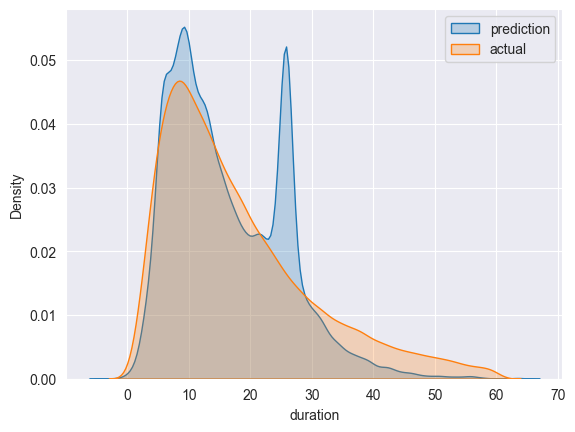

In [14]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)
plt.legend()
plt.show()

In [15]:
root_mean_squared_error(y_val, y_pred)

7.758715200888857

In [22]:
alpha = .01
lasso = Lasso(alpha=alpha)
train_model(lasso, X_train, y_train)
y_pred = lasso.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)

with mlflow.start_run():
    mlflow.set_tag("developer", "Armand Winant")

    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("validation-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")

    mlflow.log_param("alpha", alpha)

    mlflow.log_metric("rmse", rmse)


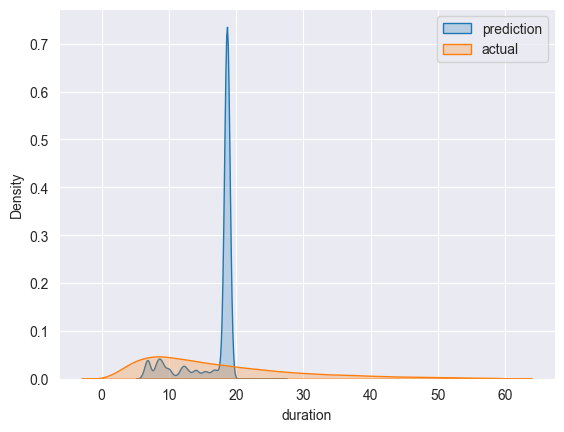

In [17]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)
plt.legend()
plt.show()

In [18]:
root_mean_squared_error(y_val, y_pred)

11.167275941179728

In [19]:
ridge = Ridge(alpha=.01)
train_model(ridge, X_train, y_train)
y_pred = ridge.predict(X_val)

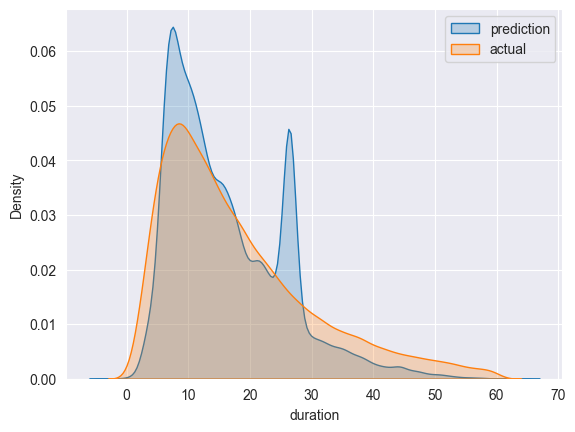

In [20]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)
plt.legend()
plt.show()

In [84]:
root_mean_squared_error(y_val, y_pred)

7.509752258177714

In [21]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)